# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

**Импортируем библиотеку pandas. Считаем данные из csv-файла в датафрейм и сохраните в переменную `data`. Путь к файлу:**

`/datasets/real_estate_data.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv')

**Также запросим информацию о датасете с помощью метода info():**

In [2]:
data.info()
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                                                           --------------  ----- 
 0   total_images	last_price	total_area	first_day_exposition	rooms	ceiling_height	floors_total	living_area	floor	is_apartment	studio	open_plan	kitchen_area	balcony	locality_name	airports_nearest	cityCenters_nearest	parks_around3000	parks_nearest	ponds_around

23699 строк и всего одна колонка, выглядит, как будто данные повреждены или неправильно интерпретированы. Однако, если мы выведем датасет, то увидим, что в качестве разделитя используется табуляция, и **проблема решается, если задать аргумент sep внутри read_csv.**

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Теперь имеем целый 21 атрибут, но проблемы на этом не заканчиваются, мы видим явные пропуски значений в более чем половине колонок. О природе этих пропусков, поговорим в предобработке данных, а сейчас **построим гистограмму для всех столбцов таблицы:**

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

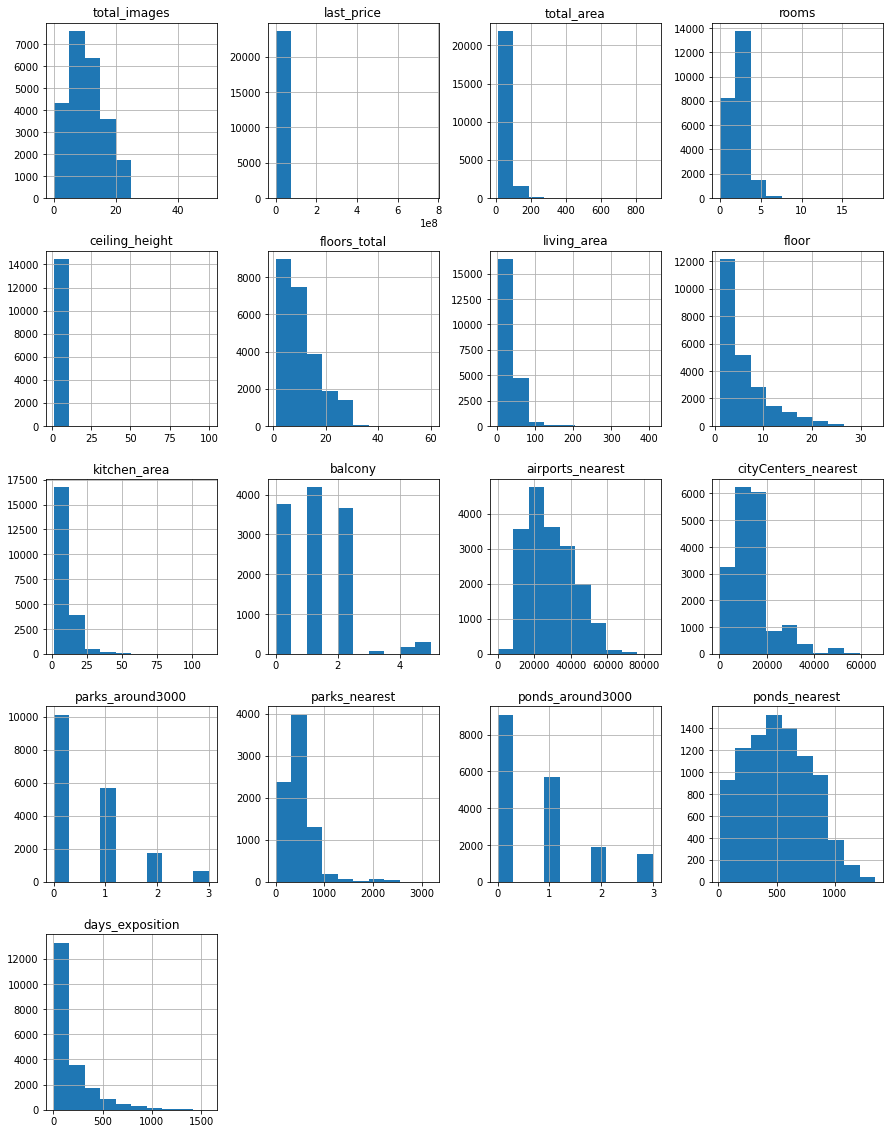

In [4]:
data.hist(figsize=(15, 20))

На первый взгляд видны явные проблемы с last_price - ценой на момент снятия с публикации, и вряд ли все почти 24000 объявления дружно занялись благотворительностью, при обработке данных на этот столбец необходимо обратить внимание. Также непонятно, что с ceiling_height - высотой потолков, может проблема в масштабировании графика, ведь разброс в высоте потолков небольшой 2-4 метра и гистограмма в таком формате может искозить представление. В гистограмме balcony - с числом балконов тоже есть сомнительное значение, а именно float, поскольку количество балконов - число целое, непонятно, откуда оно там появилось. На эти столбцы обратим внимание при предобработке данных.

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Странно наблюдать минимальные значения в столбцах rooms (как комнат может быть 0?), ceiling_height (потолки в 1 метр могут подойти лишь детям в возрасте до 10 лет, но они себе квартиру позволить не могут), living_area (2 метра жилой площади в самый необъятной стране мира - странно), kitchen_area (чуть более метра жилой площади в самый необъятной стране мира - не менее странно, чем с жилой площадью), airports_nearest (вряд ли кто-то поселился в зале ожидания, у нас тут не фильм Терминал все-таки) и parks_nearest (1 метр до парка тоже сомнительно, надо бы проверить)

### Предобработка данных

Выведем количество пропущенных значений для каждого столбца:

In [6]:
print(data.isnull().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Количество пропусков зашкваливает. Будем разбираться со всем поочередно.

#### Столбец ceiling_height

In [7]:
print(data['ceiling_height'].isnull().sum())
print(data['ceiling_height'].unique())

9195
[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.4

Рассмотрим столбец с высотой потолков, и обратим внимание, что очень много аномальных значений, например, высота потолков больше 5 метров (уже достаточно экзотично), или менее 2.1 (насколько можно доверять поисковику - это минимальное значение потолков жилого помещения). Значит все значения менее 2.1 можно приравнять к 2.1, то же самое сделать с потолками, что более 5.

In [8]:
print(data[data['ceiling_height'] < 2.1]['ceiling_height'].count() + data[data['ceiling_height'] > 5]['ceiling_height'].count())

50


50 строк в масштабе почти 26000 не сыграют большой роли, значит можем заменить, а после заполнить пустоты средними значениями. Хоть и в техническом задании указано попробовать привести значения к нормальному виду с помощью умножения на 0,1, мне кажется, такой вариант решения более прост, мы сжимаем выборку, избавляемся от аномалий, и не теряем данные. И в данном случае, кстати, можно воспользовать средним арифмитическим, поскольку мы защитились от аномальных выбросов.

In [9]:
data['ceiling_height'] = data['ceiling_height'].where(~(data['ceiling_height'] < 2.1),2.1)
data['ceiling_height'] = data['ceiling_height'].where(~(data['ceiling_height'] > 5),5)
data['ceiling_height'] = data['ceiling_height'].where(~(data['ceiling_height'].isnull()),data['ceiling_height'].median())

print(data['ceiling_height'].isnull().sum())
print(data['ceiling_height'].unique())

0
[2.7  2.65 3.03 2.5  2.67 2.56 3.05 2.75 2.6  2.9  2.8  2.55 3.   3.2
 2.61 3.25 3.45 2.77 2.85 2.64 2.57 4.15 3.5  3.3  2.71 4.   2.47 2.73
 2.84 3.1  2.34 3.4  3.06 2.72 2.54 2.51 2.78 2.76 5.   2.58 3.7  2.52
 2.87 2.66 2.59 2.1  2.45 3.6  2.92 3.11 3.13 3.8  3.15 3.55 3.16 3.62
 3.12 2.53 2.74 2.96 2.46 2.79 2.95 4.06 2.94 3.82 3.54 3.53 2.83 4.7
 2.4  3.38 3.01 3.65 3.9  3.18 3.35 2.3  3.57 2.48 2.62 2.82 3.98 2.63
 3.83 3.52 3.95 3.75 2.88 3.67 3.87 3.66 3.85 3.86 4.19 3.24 4.8  4.5
 4.2  3.36 3.08 3.68 3.07 3.37 3.09 3.26 3.34 2.81 3.44 2.97 3.14 4.37
 2.68 3.22 3.27 4.1  2.93 3.46 3.47 3.33 3.63 3.32 2.98 2.86 3.17 4.4
 3.28 3.04 4.45 3.84 3.23 3.02 3.21 3.43 3.78 4.3  3.39 2.69 3.31 4.65
 3.56 2.2  3.51 3.93 3.42 2.99 3.49 4.14 2.91 3.88 4.25 3.29 2.25 3.76
 3.69 2.89 3.58 2.49 4.9  3.48 3.59]


#### Столбец floors_total

Следующий столбец - всего этажей в доме, непонятно, по каким причинам пропуск, может забывчивость риелтора. Но заполнять пропуски медианными значениями - не вариант, все-таки количество этажей это вряд ли подходящая группа для заполнения подобным родом.
Вероятно, 86 пропусков - не такая большая потеря для нашего датасета, и мы можем их убрать, однако можем и сохранить, если запоним каким-либо значением, вряд ли этажность дома очень влияющая на исследование значение, а остальные данные могут и пригодиться. Так как заполнять медианными - невариант, можно заполнить самым большим этажом встречающимся в выборке, вряд ли безэтажный - может его переплюнуть.

In [10]:
print(data['floors_total'].isnull().sum())
max_floor = data['floors_total'].max()
data['floors_total'] = data['floors_total'].where(~(data['floors_total'].isnull()),max_floor)
print(data['floors_total'].isnull().sum())

86
0


#### Столбцы living_area и rooms

Данный столбец отображает количество жилой площади в квартире, первое, что надо помнить, что минимальное значение в данном столбце 2 - что очень мало, надо оценить количество аномалий, их причину и заполнить пропуски. Заполнять пропуски медианным значением всего столбца - плохая идея, ведь, можно категоризировать данные, ведь средняя жилая площадь однокомнатной и трехкомнатной - отличаются. Для этого необходимо написать функцию.

In [11]:
print(data['rooms'].unique())
data['rooms'] = data['rooms'].where((data['rooms'] != 0),1)
print(data['rooms'].unique())

[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
[ 3  1  2  4  5  6  7 11  8 14 10 15  9 19 16 12]


Но как откинуть странные значения и являются ли данные значения аномальными - мне не понятно. Но прежде чем описывать функцию, необходимо починить столбец rooms, поскольку там существует значение 0, которого быть не должно, вероятно там просто 1 комната. Хотя и 19 выглядит странно, но я не знаю, что с этим поделать! Не хочется портить датасет, но тут https://poznayka.org/s7736t2.htm описаны минимальная квадратура жилового помещения по количеству комнат, если необходимо, можно написать функцию, которая докинет минимальный с законодательной стороны порог, там где его явно не хватает. Я опишу данную функцию, но применять не буду, поскольку не до конца понимаю, стоит ли делать подобным образом, поскольку в тз это не указано, и вероятно сильно повлияет на данные.

In [12]:
def min_living_area(row):
    if row["rooms"] == 1 and row['living_area'] < 18:
        row['total_area'] += 18 - row['living_area']
        row['living_area']  = 18
    elif row["rooms"] == 2 and row['living_area'] < 27:
        row['total_area'] += 27 - row['living_area']
        row['living_area']  = 27
    elif row["rooms"] == 3 and row['living_area'] < 38:
        row['total_area'] += 38 - row['living_area']
        row['living_area']  = 38
    elif row["rooms"] == 4 and row['living_area'] < 56:
        row['total_area'] += 56 - row['living_area']
        row['living_area']  = 56
    elif row["rooms"] >= 5 and row['living_area'] < 58:
        row['total_area'] += 58 - row['living_area']
        row['living_area']  = 58
    return row
        

Воспользуемся функцией, которая заменит пропуски на медианные значения в зависимости от количества комнат в квартире:

In [13]:
def metr_per_rooms(col):
    rooms = data['rooms'].unique()
    for i in rooms:
        data.loc[(data['rooms']==i)&(data[col].isnull()), col] = data[data['rooms']==i][col].median()
    return data

data = metr_per_rooms('living_area')
print(data['living_area'].isnull().sum())

0


#### Столбец is_apartment

В данном столбце очень много пропусков по непонятным причинам, и определить что есть аппартаменты, а что нет - тяжело. Поэтому просто заполним пропуски значением False, поскольку даже из тех, что заполнены - они встречаются гораздо реже.

In [14]:
data['is_apartment'].value_counts()
data['is_apartment'] = data['is_apartment'].where(~data['is_apartment'].isnull(), False)

#### Столбец kitchen_area

Логично предположить, что размеры кухни, прямопропорциональны размеру квартиры, а следовательно и количеству комнат. Мы можем применить функцию, описанную ранее и заполнить пропуски по медиане кухонь соответствующей комнатности.

In [15]:
data = metr_per_rooms('kitchen_area')
print(data['kitchen_area'].isnull().sum())

0


#### Столбец balcony

В данном столбце на предварительном анализе помимо пропусков были еще значения float, хотя количество балконов - число целое, об этом следует помнить! 

In [16]:
print(data['balcony'].unique())

[nan  2.  0.  1.  5.  4.  3.]


По всей видимости, я криво прочитал гистограмму. Никаких десятичных и прочих дробных чисел тут нет, но все же привести к int необходимо, для спокойствия души, а так же заполнить пропуски нулями, потому что - раз не описали, то скорее всего их и не было.

In [17]:
data['balcony'] = data['balcony'].where(~(data['balcony'].isnull()),0)
data['balcony'] = data['balcony'].astype(int)
print(data['balcony'].unique())

[0 2 1 5 4 3]


#### Столбец locality_name

К сожалению, в данном столбце тяжело запонить пропуски, ведь средним арифмитическим или медианой тут не поможешь. Вывод один - заменить на "неизвестно", как мы это делали ранее, и заодно проверить на дубликаты.

In [18]:
#print(len(data['locality_name'].unique()))
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
data['locality_name'] = data['locality_name'].where(~data['locality_name'].isnull(),'неизвестно')
#print(len(data['locality_name'].unique()))
wrong_genres = ['поселок', 'деревня', 'городской', 'садовое', 'типа', 'городского', 'товарищество', 'садоводческое некоммерческое'] # переменная с неправильным списком
for index in wrong_genres: # перебираем список с неправильными значениями
    data['locality_name'] = data['locality_name'].str.replace(index+' ', '', regex=True)
#print(len(data['locality_name'].unique()))

data['locality_name'] = data.locality_name.str.capitalize()


print(data['locality_name'].unique())
#for i in data['locality_name']:
    #for j in data['locality_name']:
        #if i in j:
            #data['locality_name'] = data['locality_name'].str.replace(j, i, regex=True)
#print(len(data['locality_name'].unique()))
#data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
#data['locality_name'] = data['locality_name'].str.replace('', '', regex=True)
#print(len(data['locality_name'].unique()))
#print(data['locality_name'].unique().tolist())
#for i in data['locality_name']:
    #i = i.strip()
#рябово, мурино, кудрово, федоровское
#def replace_wrong_genres(wrong_genres, correct_genre): #создание функции с двумя параментрами
    #for index in wrong_genres: # перебираем список с неправильными значениями
        #df['genre_name'] = df['genre_name'].replace(index, correct_genre, inplace = True) # replace для каждого неправильного наименования
#first_name = ['hip', 'hop', 'hip-hop'] # переменная с неправильным списком
#two_name = 'hiphop' # переменная с правильным значением

['Санкт-петербург' 'Шушары' 'Янино-1' 'Парголово' 'Мурино' 'Ломоносов'
 'Сертолово' 'Петергоф' 'Пушкин' 'Кудрово' 'Коммунар' 'Колпино'
 'Красный бор' 'Гатчина' 'Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'Новое девяткино' 'Металлострой' 'Лебяжье' 'Сиверский' 'Молодцово'
 'Кузьмоловский' 'Новая ропша' 'Павловск' 'Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' 'Куттузи' 'Аннино'
 'Ефимовский' 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское'
 'Красное село' 'Понтонный' 'Сясьстрой' 'Старая' 'Лесколово' 'Новый свет'
 'Сланцы' 'Село путилово' 'Ивангород' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры'
 'Рощино' 'Кириши' 'Луга' 'Волосово' 'Отрадное' 'Село павлово' 'Оредеж'
 'Село копорье' 'Молодежное' 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно'
 'Стрельна' 'Бокситогорск' 'Александровская' 'Лопухинка' 'Пикалево'
 'Терволово' 'Советский' 'Подпорожье' 'Петровское' 'Токсово' 'Сельцо'
 'Вырица' 'Кипень' 'Келози' 'Вартемяг

К сожалению, тут есть трудности, цикл в цикле в цикле имеет огромную сложность и ничего не прогружается, очевидно. Вообще была мысль удалить все слова из рода "поселок", "деревня" и т.д, но выходит некоторая ерунда, да и потом к этим названием не вернешься, короче немного не понимаю, как тут совершить волшебство очистки данных. Есть проблемы с strip(), почему то он не дает совершить эту функцию для элементов столбца и сохранить в этот же столбец, применил какие-то костыли, вроде вышло.

#### Столбцы airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000 и ponds_nearest

В данные столбцы непонятно чем заменять пропуски, ничего кроме как заполнить их "неизвестностью" не приходит в голову, но даже они не подойдут, ведь тип данных - float. Что делать в данной ситуации? Можем предположить, что данных по районам - достаточно, и расстояния от различных районов равны, тогда мы можем поставить медианные значения в тех местах, в соответствии с местоположением - для этого достаточно изменить написанную ранее функцию. Но стоит учесть, что количество прудов и парков - число целое. Идея проста, сначала я заполняю данные расстояния до парков, прудов и т.д. с помощью функции категоризации среднего значения по локации, после сравниваю, если эти столбцы не пусты - значит рядом есть хотя бы 1 пруд или парк (но это условие у меня выполняется криво, да и терзают ли некоторые сомнения, необходимо ли это, поэтому пока что не стану делать подобным образом).

In [19]:
median_data = data.pivot_table(
    index='locality_name',
    values=['airports_nearest', 'cityCenters_nearest','parks_nearest','ponds_nearest'],
    aggfunc='median'
)
#print(median_data)
median_data_localities = list(median_data.index)
def fill_missing_data(row, col):
    locality = row['locality_name']
    
    if locality in median_data_localities:
        return median_data.loc[locality][col]
    
    return row[col]

columns = ['airports_nearest', 'cityCenters_nearest','parks_nearest','ponds_nearest']

for column in columns:
    data.loc[data[column].isnull(), column] = data.apply(fill_missing_data, axis=1, args=(column,))

#data['parks_around3000'] = data['parks_around3000'].where((data['parks_nearest'] < 3000) & (data['parks_around3000'].isna()), 1)
#data['ponds_around3000'] = data['ponds_around3000'].where((data['ponds_nearest'] < 3000) & (data['ponds_around3000'].isna()), 1)

#print(data.query('ponds_around3000.isna() and ponds_nearest < 3000').count()) # ура неработающее условие нашел
#print(data.query('parks_around3000.isna() and parks_nearest < 3000').count())

#def value_per_locality(col):
    #locality = data['locality_name'].unique()
    #for i in locality:
        #data.loc[(data['locality_name']==i)&(data[col].isnull()), 'locality_name'] = data[data['locality_name']==i][col].mean()
    #return data

#data = value_per_locality('parks_nearest')
#data = value_per_locality('ponds_nearest')
#data = value_per_locality('airports_nearest')
#data = value_per_locality('cityCenters_nearest')
#ponds_around3000

#locality = data['locality_name'].unique()
#for i in locality:
    #data.loc[(data['locality_name']==i)&(data['ponds_nearest'].notna())&(data['ponds_around3000'].isnull()), 'locality_name'] = 1
    #data.loc[(data['locality_name']==i)&(data['parks_nearest'].notna())&(data['parks_around3000'].isnull()), 'locality_name'] = 1
#data = value_per_locality('parks_nearest')
#data = value_per_locality('ponds_nearest')
#print(data['parks_nearest'].isnull().sum())
#print(data['ponds_nearest'].isnull().sum())
#print(data['ponds_around3000'].isnull().sum())
#print(data['parks_around3000'].isnull().sum())


#data['ceiling_height'] = data['ceiling_height'].where(~(data['ceiling_height'] > 5),5)
#data['ceiling_height'] = data['ceiling_height'].where(~(data['ceiling_height'].isnull()),data['ceiling_height'].median())

#(df1.A != df2.A) | (df1.B != df2.B)
#data.query('parks_nearest.notna() and parks_nearest<=3000 and parks_around3000.isna()') = data.query('parks_nearest.notna() and parks_nearest<=3000 and parks_around3000.isna()').fillna(1) 

#data['Normalized'] = np.where(df['Currency'] == '$', df['Budget'] * 0.78125, df['Budget'])

#print(data['cityCenters_nearest'].isnull().sum())
#print(data['airports_nearest'].isnull().sum())
#print(data['parks_nearest'].isnull().sum())
#print(data['ponds_nearest'].isnull().sum())
#print(data['ponds_around3000'].isnull().sum())
print(data.isnull().sum())


total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        4829
cityCenters_nearest     4829
parks_around3000        5518
parks_nearest           5998
ponds_around3000        5518
ponds_nearest           4938
days_exposition         3181
dtype: int64


Настрадался я тут, но даже в этом случае, я все равно не зачистил датасет от nanoв до конца, к сожалению данных даже по областям недостаточно. Вроде в голове выглядит логично, но выходит странная история, с условием беда как будто:C

#### Столбец days_exposition

Восстановить данные по дням - невозможно, поэтому придется просто удалить их.

In [20]:
data.dropna(subset=['days_exposition'], axis = 0, inplace = True)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

**Вывод по главе**: были устранены большинство пропусков и аномальных значений, а также выдвинуты теории появления ошибок в данных. К сожалению, число nanoв остается все равно в столбцах с расстоянием до аэропортов, центра города, парков, озер, а также их количествах. Но подождите меня судить, было их почти в 4 раза больше! Однако, я допускаю возможность своего фиаско, поскольку с расстоянием до необходимых точек, и количеством парков и прудов все неоднозначно.

### Посчитайте и добавьте в таблицу новые столбцы

В данной главе необходимо добавить новые столбцы:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [50]:
data['cost_per_metr'] = data['last_price'] / data['total_area'] 

data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

def which_floor(row):
    our = row['floor']
    how_much = row['floors_total']
    if how_much / our == how_much:
        return 'первый'
    elif how_much / our == 1:
        return 'последний'
    else:
        return 'другой'
    
data['which_floor'] = data.apply(which_floor, axis=1)

data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']*0.001)

data['last_price'].unique()

array([ 3350000.,  5196000., 64900000., ...,  3063600.,  6151120.,
       11475000.])

Вывод по главе: в данной главе отработали добавление новых, необходимых для дальнейшего анализа столбцов.

### Проведите исследовательский анализ данных

#### Изучаем параметры объектов

##### Параметр "общая площадь"

<AxesSubplot:>

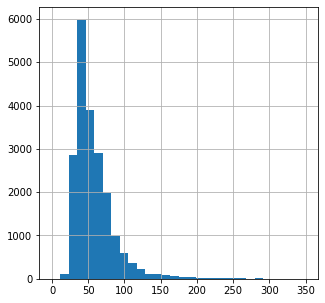

In [79]:
data['total_area'].hist(figsize=(5, 5), bins = 30, range = (0,350))

Почти все значения общей площади находятся в промежутке до 200 квадратных метров, что вполне может соответствовать реальности, каких то аномалий и огромных явных вбросов тут нет.

##### Параметр "жилая площадь"

<AxesSubplot:>

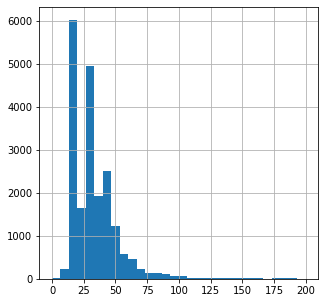

In [77]:
data['living_area'].hist(figsize=(5, 5), bins = 30, range = (0,200))

В данном случае есть сомнения, поскольку параметры начинаются с нуля, выше я описывал функцию, но не вызывал ее, для тех значений, где жилая площадь аномально мала. Видимо тут эта аномалия и отобразилась, в целом можно вызвать и уладить моменты с экстримально низкими значениями, но надо ли - непонятно. А так все в целом хорошо, жилая площадь вполне себе может достигать 200 метров.

##### Параметр "площадь кухни"

<AxesSubplot:>

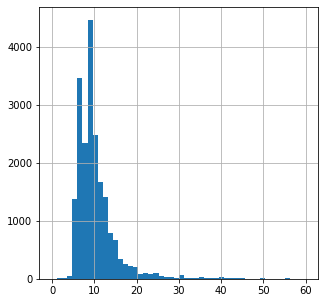

In [75]:
data['kitchen_area'].hist(figsize=(5, 5), bins = 50, range = (0,60))

В этих данных аналогично, на мой взгляд, все нормально.

##### Параметр "цена объекта"

<AxesSubplot:>

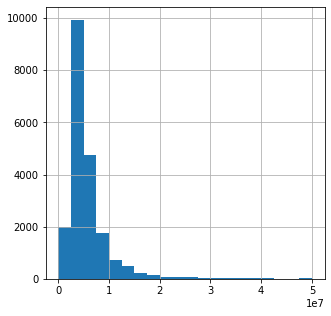

In [72]:
data['last_price'].hist(figsize=(5, 5), bins = 20, range=(0, 50000000))

Что же, бОльшая часть недвижимости обойдется вам меньше чем за 10 миллионов рублей.

##### Параметр "количество комнат"

array([ 1,  2,  3,  4,  5,  6,  7,  8, 14, 15,  9, 11, 19, 10, 16, 12])

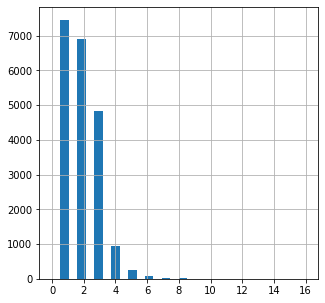

In [74]:
data['rooms'].hist(figsize=(5, 5), bins = 30, range = (0,16))
data['rooms'].unique()

Мы видим, что в данных встречаются и 10+ комнатные квартиры, однако на гистограмме их не видно - видимо такие квартиры огромная редкость, по-хорошему от них можно избавится, но это не значит, что такие квартиры не могут существовать! Если бы наш анализ касался поиска закономерностей в эконом-секторе, то, конечно, но пока что лучше оставить как есть.

##### Параметр "высота потолков"

<AxesSubplot:>

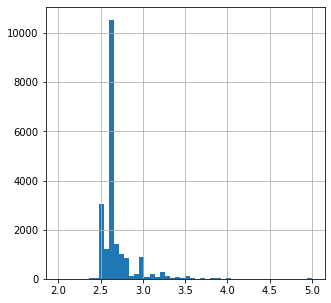

In [80]:
data['ceiling_height'].hist(figsize=(5, 5),bins = 50, range = (2,5))

Здесь провели хорошую зачистку от аномальных значений, видно, что большинство квартир построены по советским стандартам с высотой 2.7 и это замечательно!

##### Параметр "этаж квартиры"

<AxesSubplot:>

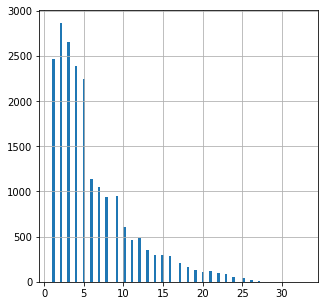

In [28]:
data['floor'].hist(figsize=(5, 5),bins = 100)

Наблюдаем замечательную картину, что чем выше этаж - тем реже он встречается, ну оно и понятно, пятиэтажек в разы больше, чем многоквартирников на 20+ этажей, соответственно и объявлений больше.

##### Параметр "тип этажа квартиры"

<AxesSubplot:>

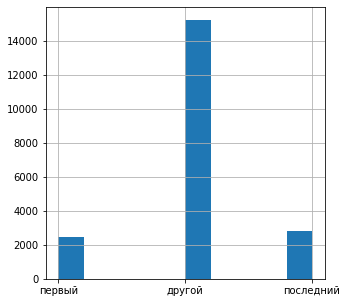

In [29]:
data['which_floor'].hist(figsize=(5, 5))

Сравнивая с параметром выше мы определенно точно можем сказать, что функция сработала как надо с первым этажом, что там, что тут примерно 2500 объявлений.

##### Параметр "общее количество этажей в доме"

<AxesSubplot:>

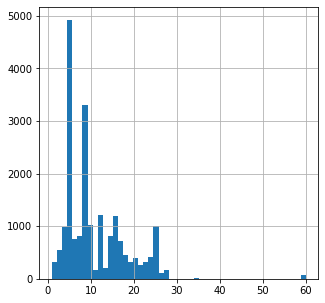

In [30]:
data['floors_total'].hist(figsize=(5,5),bins=50)

Аналогичная ситуация с параметром "этаж квартиры".

##### Параметр "расстояние до центра города в метрах"

<AxesSubplot:>

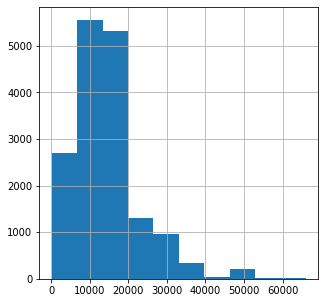

In [31]:
data['cityCenters_nearest'].hist(figsize=(5,5))

Выглядит правдаподобно, может и хорошо, что мы не стали заполнять пропуски сомнительными медианами.

##### Параметр "расстояние до ближайшего аэропорта"

count    16475.000000
mean     29630.951108
std      13168.391751
min          0.000000
25%      18748.000000
50%      27314.000000
75%      39106.000000
max      84869.000000
Name: airports_nearest, dtype: float64

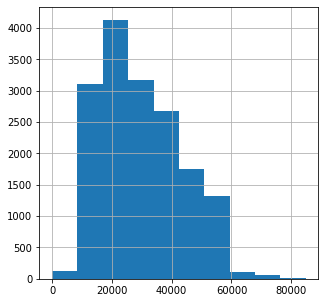

In [32]:
data['airports_nearest'].hist(figsize=(5,5))
data['airports_nearest'].describe()

Выглядит правдаподобно, может и хорошо, что мы не стали заполнять пропуски сомнительными медианами. Правда в данном случае имеет место быть 0 метров до аэропорта, и если считать капсульный отель отдельной студией, может так оно и есть, но не знаю!

##### Параметр "расстояние до ближайшего парка"

count    15391.000000
mean       476.284419
std        236.128673
min          1.000000
25%        428.500000
50%        460.000000
75%        460.000000
max       3190.000000
Name: parks_nearest, dtype: float64

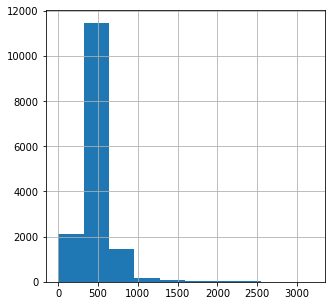

In [33]:
data['parks_nearest'].hist(figsize=(5,5))
data['parks_nearest'].describe()

1 метров до парка тоже может смутить, вряд ли кто-то построил многоэтажку посреди парка - максимум через дорогу и метр для этого маловато.

##### Параметр "день и месяц публикации объявления"

<AxesSubplot:>

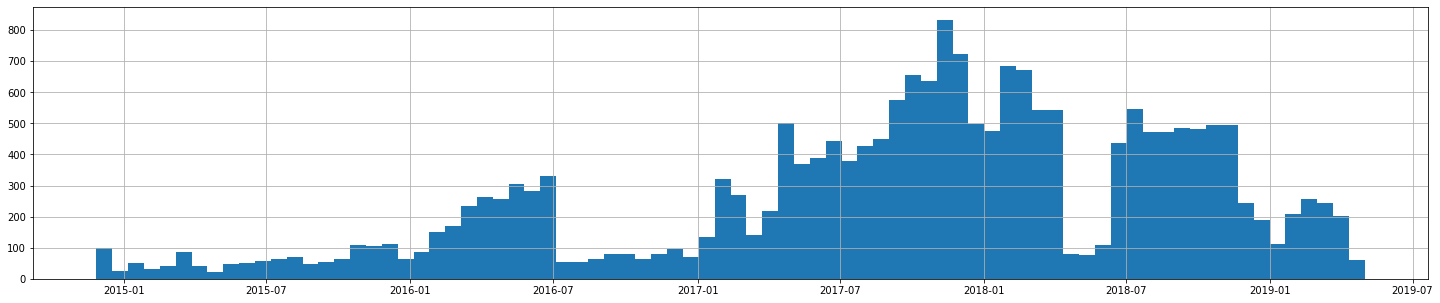

In [34]:
data['first_day_exposition'].hist(figsize=(25,5),bins = 80)

На данном графике мы наблюдаем рассвет арендной сдачи во второй половине 2017 - начале 2018 года, оно и понятно, поскольку именно в этот промежуток стало известно, что Чемпионат Мира по футболу будет проводиться в нашей стране, и именно в Петербурге пройдут некоторые матчи, так что можно связать именно с этим.

#### Изучим, как быстро продавались квартиры с помощью параметра days_exposition

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

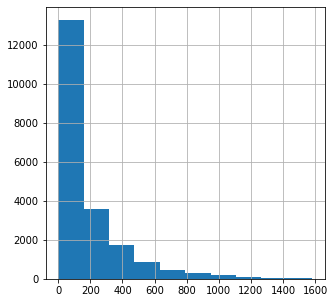

In [35]:
data['days_exposition'].hist(figsize=(5,5))
data['days_exposition'].describe()

Данный график напоминает нам распределение пуассона, что вполне логично. Третий квартиль находится на значении 232, а значит, что три четвертых всех объявлений уходит примерно за 8 месяцев, а все что дольше - можно назвать долгими объявлениями. Первый же квартиль на значении 45, значит, те что сдались за 1,5 месяца - можно назвать быстрыми. Среднее же значение 180 дней, то бишь полгода без аредной платы!

#### Изучим, факторы влияния на общую (полную) стоимость объекта

##### Изучим зависит ли цена от общей площади

0.643126730535294

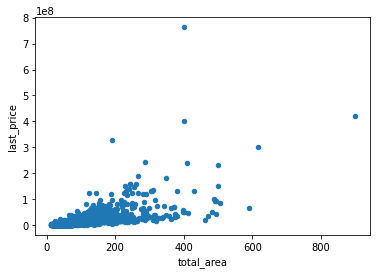

In [36]:
data.plot(x='total_area', y='last_price', kind='scatter')
data['total_area'].corr(data['last_price'])

Даже с явными аномалиями шикарных квартир от 300+ м^2 коэффициент корреляции равен около 0,64, что вполне себе позволяет сказать, что эти показатели прямопропорциональны, но не так сильно, как хотелось бы для однозначного ответа.

##### Изучим зависит ли цена от жилой площади

0.5457444935416916

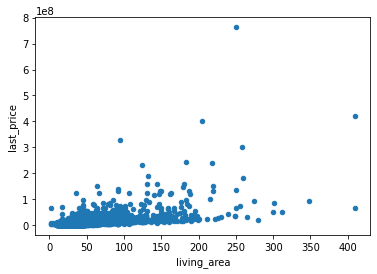

In [37]:
data.plot(x='living_area', y='last_price', kind='scatter')
data['living_area'].corr(data['last_price'])

На этом графике так же видны некоторые объявления выбивающиеся из общих тенденций, но даже с ними коэффициент корреляции составил почти 0,55, что неплохо!

##### Изучим зависит ли цена от площади кухни

0.4370587312281409

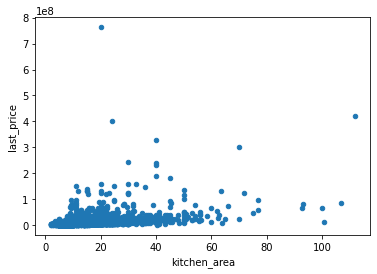

In [38]:
data.plot(x='kitchen_area', y='last_price', kind='scatter')
data['kitchen_area'].corr(data['last_price'])

На этом графике так же видны некоторые объявления выбивающиеся из общих тенденций, но даже с ними коэффициент корреляции составил почти 0,43, что неплохо, однако, на фоне остальных этот показатель более слабо влияет на стоимость!

##### Изучим зависит ли цена от количества комнат

0.35609768336865494

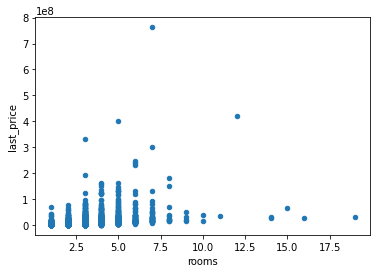

In [39]:
data.plot(x='rooms', y='last_price', kind='scatter')
data['rooms'].corr(data['last_price'])

Зависимость с каждым новым графиком все слабее! Цена от количества комнат очень слабо зависит.

##### Изучим зависит ли цена от этажа

In [40]:
data[['which_floor', 'last_price']].pivot_table(index='which_floor', values='last_price')

,last_price
which_floor,
другой,6.420232e+06
первый,4.497619e+06
последний,6.983703e+06


Здесь зависимость понятна - первый этаж часто дешевле ввиду многих причин, выглядит реалистично.

##### Изучим зависит ли цена от дня, месяца и года объявления

In [41]:
data[['weekday', 'month', 'year', 'last_price']].corr()

,weekday,month,year,last_price
weekday,1.000000,0.009927,0.006024,0.004637
month,0.009927,1.000000,-0.196851,0.005631
year,0.006024,-0.196851,1.000000,-0.061122
last_price,0.004637,0.005631,-0.061122,1.000000


Корреляция нулевая, зависимости между этими параметрами нет.

#### Рассчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [60]:
(data
 # считаем среднюю цену за квадратный метр среди топ-10 населенных пунктов
 .pivot_table(index='locality_name', aggfunc={'last_price':'count', 'cost_per_metr':'mean'})
 .sort_values(by='last_price', ascending=False)
 .head(10)
 # отсортируем таблицу еще раз по средним значениям, чтобы выделить минимум и максимум
 #.sort_values(by='cost_per_metr', ascending=False)
 #.plot(y='cost_per_metr', kind='bar', figsize=(10, 5))
)


,cost_per_metr,last_price
locality_name,,
Санкт-петербург,112412.025179,13638
Мурино,85743.233293,551
Кудрово,94408.041602,441
Шушары,78010.167480,408
Всеволожск,68570.615292,339
Колпино,74865.364347,308
Пушкин,102074.629153,307
Парголово,89505.043917,302
Гатчина,67928.326990,268


В Питере наблюдаем самые высокие показатели стоимости жилья, оно и понятно, культурная столица, город миллионник и просто прекрасное место. Однако в Москве цены подчас в два раза больше.

#### Рассчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='last_price'>

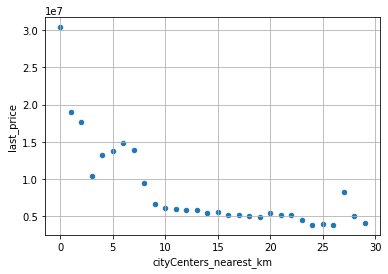

In [68]:
data_sp = data[data['locality_name'] == 'Санкт-петербург'].dropna(subset=['cityCenters_nearest']) 
(
    pd.DataFrame(data_sp.pivot_table(index='cityCenters_nearest_km', values='last_price').to_records())
    .plot(x='cityCenters_nearest_km', y='last_price', kind='scatter', grid=True)
)

Очевидно, чем ближе к центру, тем дороже, это мы и наблюдаем на данном графике. Также необходимо высчитать стоимость каждого километра согласно тз, и я немного не понимаю, как это сделать(

### Общий вывод

Предоставленные данные были достаточно грязными, но после очистки мы смогли их проанализировать и пришли к следующим выводам:
1. Цена зависит от общей площади и близости к центру (по городу Санкт-Петербург)
1. Недвижимость в северной столице стоит больше, чем в пригороде (за квадратный метр).
1. Основной объем объявлений выл вывешен в период конца 2017 - первая половина 2018, скорее всего из-за ЧМ по футболу
1. По большей части объекты продаются в течение полугода
1. Наблюдается зависимость цены от этажа, а конкретно - первого, жилье на этом этаже обойдется дешевле собратьев.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [ ]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [ ]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [ ]  посчитано и добавлено в таблицу: месяц публикации объявления
- [ ]  посчитано и добавлено в таблицу: год публикации объявления
- [ ]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [ ]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод